In [ ]:
from firedrake import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm, trange
import torch

# ML part
## Read and validate dataset
Due to the long simulation time of the cohesive crack model, the numerical model and the machine learning part are separated

In [2]:
train_data = pd.read_csv('../data/datasets/e.nu.step.cmod.csv', header=1, names=['sigx','RF','CMOD','disp','steps'])
test_data = pd.read_csv('../data/datasets/e.nu.step.cmod_test.csv', header=1, names=['sigx','RF','CMOD','disp','steps'])
train_data['E'] = 20e3
train_data['nu'] = 0.2
test_data['E'] = 20e3
test_data['nu'] = 0.2


In [3]:
train_data.head()

,sigx,RF,CMOD,disp,steps,E,nu
0,0.068527,-0.336261,0.001170,-0.002578,0.015152,20000.0,0.2
1,0.137054,-0.672523,0.002340,-0.005155,0.030303,20000.0,0.2
2,0.205582,-1.008784,0.003510,-0.007733,0.045455,20000.0,0.2
3,0.274109,-1.345045,0.004681,-0.010310,0.060606,20000.0,0.2
4,0.342636,-1.681307,0.005851,-0.012888,0.075758,20000.0,0.2


In [4]:
test_data.head()

,sigx,RF,CMOD,disp,steps,E,nu
0,0.077664,-0.381096,0.001326,-0.002921,0.017172,20000.0,0.2
1,0.155328,-0.762192,0.002652,-0.005842,0.034343,20000.0,0.2
2,0.232993,-1.143289,0.003979,-0.008764,0.051515,20000.0,0.2
3,0.310657,-1.524385,0.005305,-0.011685,0.068687,20000.0,0.2
4,0.388321,-1.905481,0.006631,-0.014606,0.085859,20000.0,0.2


In [5]:
noise_level = 0.001  # Adjustment of noise level
train_data['E'] = train_data['E'] * (1 + noise_level * np.random.randn(train_data.shape[0]))
train_data['nu'] = train_data['nu'] * (1 + noise_level * np.random.randn(train_data.shape[0]))
# E = train_data['E'].values.reshape(-1, 1)
# nu = train_data['nu'].values.reshape(-1, 1)
# steps = train_data['steps'].values.reshape(-1, 1)
test_data['E'] = test_data['E'] * (1 + noise_level * np.random.randn(test_data.shape[0]))
test_data['nu'] = test_data['nu'] * (1 + noise_level * np.random.randn(test_data.shape[0]))


In [7]:
X_train_tensor = torch.tensor(train_data[['steps', 'E', 'nu']].values, dtype=torch.float32)
y_train_tensor = torch.tensor(train_data[['CMOD', 'sigx']].values, dtype=torch.float32)
X_test_tensor = torch.tensor(test_data[['steps', 'E', 'nu']].values, dtype=torch.float32)
y_test_tensor = torch.tensor(test_data[['CMOD', 'sigx']].values, dtype=torch.float32)

In [8]:
print(X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape)

torch.Size([9099, 3]) torch.Size([9099, 2]) torch.Size([6099, 3]) torch.Size([6099, 2])


# Standardisation

In [9]:
# Compute the mean and standard deviation for the training data
X_mean = torch.mean(X_train_tensor, dim=0)
X_std = torch.std(X_train_tensor, dim=0)
y_mean = torch.mean(y_train_tensor, dim=0)
y_std = torch.std(y_train_tensor, dim=0)
# Standardize the training data
X_train_standardized = (X_train_tensor - X_mean) / X_std
y_train_standardized = (y_train_tensor - y_mean) / y_std
# Standardize the test data using the training data's statistics
X_test_standardized = (X_test_tensor - X_mean) / X_std
y_test_standardized = (y_test_tensor - y_mean) / y_std
print('mean and std ', y_mean, y_std)
print('mean and std ', X_mean, X_std)

mean and std  tensor([0.1946, 1.4714]) tensor([0.0266, 0.2157])
mean and std  tensor([1.7393e+00, 2.0000e+04, 2.0000e-01]) tensor([1.8234e-01, 2.0022e+01, 1.9985e-04])


In [10]:
print('X_train', X_train_tensor[10])
print('y_train', y_train_tensor[10])
print('\n')
print('X_train', X_train_standardized[10])
print('y_train', y_train_standardized[10])
print('\n')
print('X_train_back', X_train_standardized[10] * X_std + X_mean)
print('y_train_back', y_train_standardized[10] * y_std + y_mean)

X_train tensor([1.6667e-01, 2.0005e+04, 1.9974e-01])
y_train tensor([0.0129, 0.7538])


X_train tensor([-8.6246,  0.2317, -1.3053])
y_train tensor([-6.8278, -3.3275])


X_train_back tensor([1.6667e-01, 2.0005e+04, 1.9974e-01])
y_train_back tensor([0.0129, 0.7538])


# Machine learning models

In [11]:
import torch.nn as nn
class MLP_model(nn.Module):
    def __init__(self):
        super(MLP_model, self).__init__()
        
        # Define your model architecture
        self.fc1 = nn.Linear(3, 8)  # Input size is 6
        self.fc2 = nn.Linear(8, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 2)  # Output size is 4

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
    def predict(self, x):
        x = self.forward(x)
        return x


In [12]:
class DeepMLP_model(nn.Module):
    def __init__(self):
        super(DeepMLP_model, self).__init__()
        
        self.fc1 = nn.Linear(3, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)
        x = torch.relu(self.fc4(x))
        x = self.dropout(x)
        x = torch.relu(self.fc5(x))
        x = self.dropout(x)
        x = self.fc6(x)
        return x

    def predict(self, x):
        x = self.forward(x)
        return x


In [13]:
import torch.nn as nn

class CNN1D_model(nn.Module):
    def __init__(self):
        super(CNN1D_model, self).__init__()
        
        self.conv1 = nn.Conv1d(1, 16, 3)  # Assuming input is reshaped to (batch_size, 1, 5)
        self.fc1 = nn.Linear(16, 8)
        self.fc2 = nn.Linear(8, 2)

    def forward(self, x):
        x = x.unsqueeze(1)  # Reshape to (batch_size, 1, 5)
        x = torch.relu(self.conv1(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def predict(self, x):
        return self.forward(x)


In [14]:
class RNN_model(nn.Module):
    def __init__(self):
        super(RNN_model, self).__init__()
        
        self.rnn = nn.RNN(input_size=3, hidden_size=8, batch_first=True)  # Assuming input is reshaped to (batch_size, 5, 1)
        self.fc = nn.Linear(8, 2)

    def forward(self, x):
        x, _ = self.rnn(x.unsqueeze(1))  # Reshape to (batch_size, 5, 1)
        x = self.fc(x[:, -1, :])  # Use the last RNN output
        return x
    
    def predict(self, x):
        return self.forward(x)

# Cross validation

In [15]:
from sklearn.model_selection import KFold
import numpy as np
import torch.optim as optim
import os

WEIGHT_DECAY = 0.001  # Regularization strength

def train_cross_validation(model, dataset, k_folds, epochs, batch_size, lr, criterion, device,save_folder):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    train_losses = []
    val_losses = []
    
    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold+1}/{k_folds}")
        
        # Define data subsets for training and validation
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
        val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler)
        
        # Re-initialize model for each fold
        model_fold = model()
        model_fold.to(device)
        optimizer_fold = optim.Adam(model_fold.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
        
        # Training loop for each fold
        for epoch in tqdm(range(epochs)):
            model_fold.train()
            current_train_loss = 0.0
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer_fold.zero_grad()
                outputs = model_fold(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer_fold.step()
                current_train_loss += loss.item()
                
            current_val_loss = 0.0
            model_fold.eval()
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model_fold(inputs)
                    loss = criterion(outputs, targets)
                    current_val_loss += loss.item()
            
            train_losses.append(current_train_loss/len(train_loader))
            val_losses.append(current_val_loss/len(val_loader))
            
            if epoch == epochs - 1:
                print(f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
            # Save model if the validation loss has decreased
            best_val_loss = np.Inf
            if current_val_loss < best_val_loss:
                best_val_loss = current_val_loss
                torch.save(model_fold.state_dict(), os.path.join(save_folder, f'best_rnn_model.pt'))
    # Plotting after all folds
    plt.figure(figsize=(12,4))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.title('Training and Validation Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

Fold 1/2


100%|██████████| 400/400 [03:13<00:00,  2.07it/s]


Train Loss: 0.0203, Val Loss: 0.0323
Fold 2/2


100%|██████████| 400/400 [04:45<00:00,  1.40it/s]

Train Loss: 0.0198, Val Loss: 0.0143


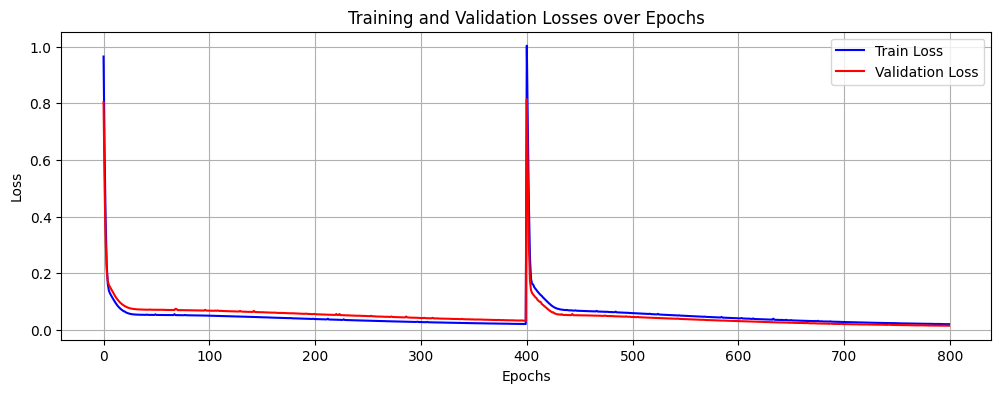

In [16]:
import torch
import torch.optim as optim

# Initialize the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Initialize the model, criterion and optimizer
model = RNN_model().to(device)
criterion = nn.MSELoss()
# Hyperparameters
EPOCHS = 400
LEARNING_RATE = 0.0004
BATCH_SIZE = 32
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Dataset loading utilities
train_dataset = torch.utils.data.TensorDataset(X_train_standardized, y_train_standardized)
test_dataset = torch.utils.data.TensorDataset(X_test_standardized, y_test_standardized)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
save_folder = '../saved_models'
# Using the function:
combined_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])
train_cross_validation(RNN_model, combined_dataset, k_folds=2, epochs=EPOCHS,batch_size=BATCH_SIZE, lr=LEARNING_RATE, criterion=criterion, device=device, save_folder=save_folder)


# Validation using RNN model

In [17]:
# Load the trained model
model_path = "../saved_models/best_rnn_model.pt"
model = RNN_model()  # assuming this is the correct name of the CNN model
model.load_state_dict(torch.load(model_path))
model.eval()

RNN_model(
  (rnn): RNN(3, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=2, bias=True)
)

0.005


Text(0.5, 1.0, 'sigx vs CMOD')

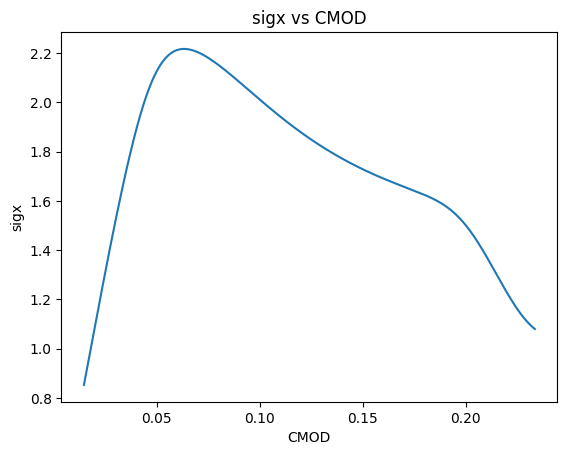

In [18]:
import torch
import torch.optim as optim
import csv
m_input = [i/200 for i in range(0, 400)]  # This will give you values from 0 to 2 with a step of 0.005

E = 20e3
nu = 0.2
sigx = []
CMOD = []
for i in m_input:
    pred_input = torch.tensor([[i, E, nu], [i,E,nu], [i,E,nu]], dtype=torch.float32)
    pred_input = (pred_input - X_mean) / X_std
    output = model.predict(pred_input)
    output = output[0] * y_std + y_mean
    output = output.detach().numpy()
    sigx.append(output[0])
    CMOD.append(output[1])

data = list(zip(sigx, CMOD))
with open('../data/datasets/cohesive_crack_data/cohesive_crack_train_rnn.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["sigx", "CMOD"])  # Header
    writer.writerows(data)
print(m_input[1])
plt.plot(sigx, CMOD)
plt.xlabel('CMOD')
plt.ylabel('sigx')
plt.title('sigx vs CMOD')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


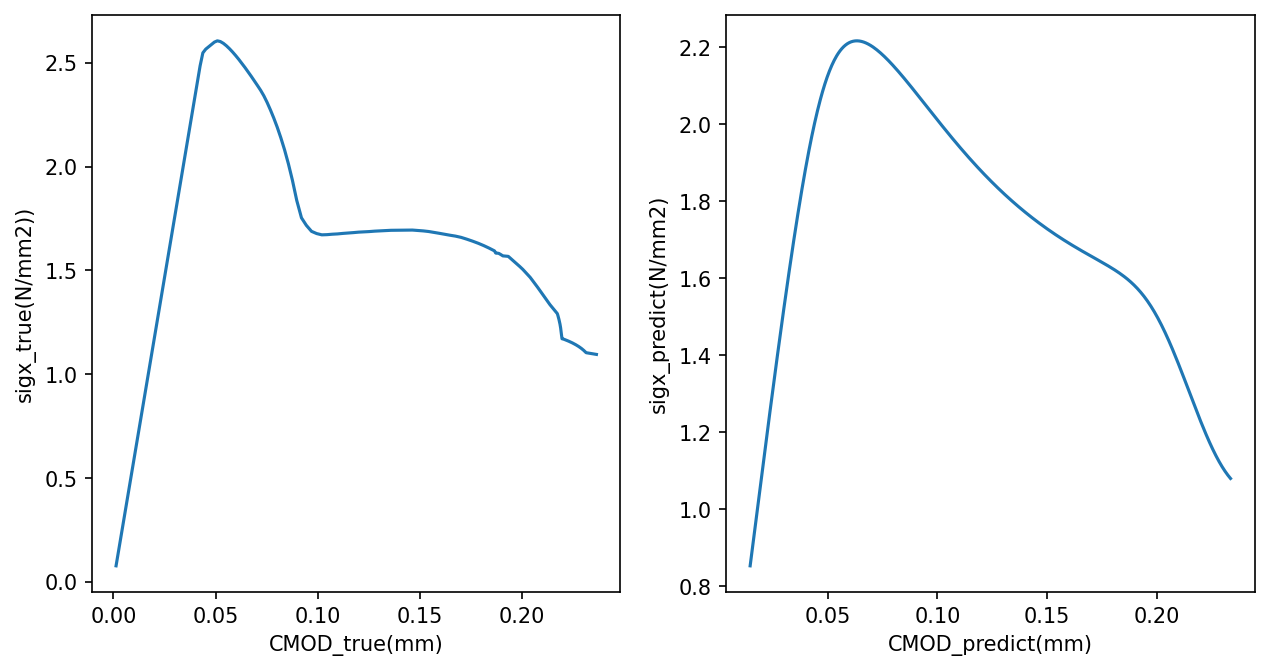

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5), dpi=150)
all_colors=['red','blue']
marks = ['o', 's']

ax[0].plot( test_data['CMOD'],test_data['sigx'])
ax[0].set_xlabel(r'CMOD_true(mm)')
ax[0].set_ylabel(r'sigx_true(N/mm2))')
ax[0].legend(frameon=False, loc='best')

ax[1].plot(sigx, CMOD)
ax[1].set_xlabel(r'CMOD_predict(mm)')
ax[1].set_ylabel(r'sigx_predict(N/mm2)')
ax[1].legend(frameon=False, loc='best')

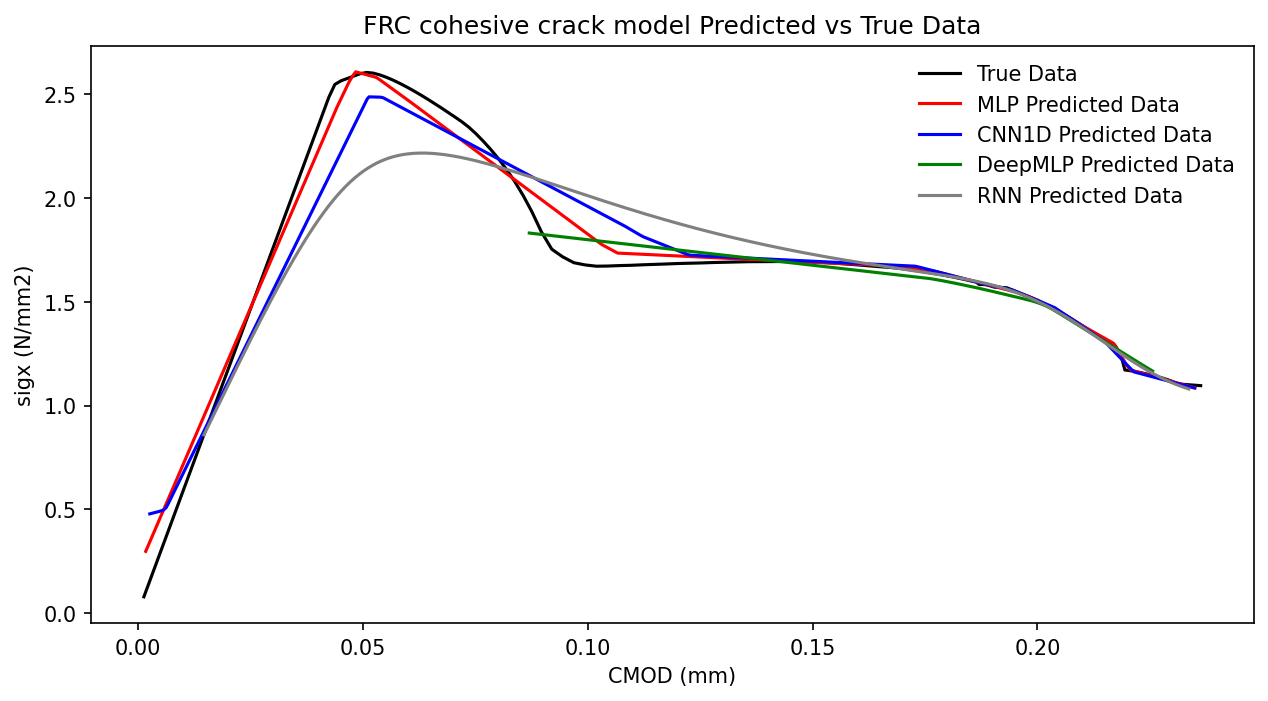

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5), dpi=150)
all_colors = ['black','red', 'blue','green','grey']

mlp_data = pd.read_csv('../data/datasets/cohesive_crack_data/cohesive_crack_train_mlp.csv', header=1, names=['sigx','CMOD'])
cnn1d_data = pd.read_csv('../data/datasets/cohesive_crack_data/cohesive_crack_train_cnn1d.csv', header=1, names=['sigx','CMOD'])
deepmlp_data = pd.read_csv('../data/datasets/cohesive_crack_data/cohesive_crack_train_deepmlp.csv', header=1, names=['sigx','CMOD'])
rnn_data = pd.read_csv('../data/datasets/cohesive_crack_data/cohesive_crack_train_rnn.csv', header=1, names=['sigx','CMOD'])

# Plotting the True data set
ax.plot(test_data['CMOD'], test_data['sigx'], color=all_colors[0], label='True Data')

# Plotting the MLP predicted data set
ax.plot(mlp_data['sigx'], mlp_data['CMOD'], color=all_colors[1], label='MLP Predicted Data')

# Plotting the CNN predicted data set
ax.plot(cnn1d_data['sigx'], cnn1d_data['CMOD'], color=all_colors[2], label='CNN1D Predicted Data')

# Plotting the DeepMLP predicted data set
ax.plot(deepmlp_data['sigx'], deepmlp_data['CMOD'], color=all_colors[3], label='DeepMLP Predicted Data')

# Plotting the RNN predicted data set
ax.plot(rnn_data['sigx'], rnn_data['CMOD'], color=all_colors[4], label='RNN Predicted Data')

ax.set_xlabel(r'CMOD (mm)')
ax.set_ylabel(r'sigx (N/mm2)')
ax.legend(frameon=False, loc='best')
ax.set_title('FRC cohesive crack model Predicted vs True Data')

plt.show()


In [21]:
sigx[1]

0.014683962

In [22]:
CMOD[1]

0.85873467